In [1]:
import ee, datetime
import pandas as pd
import numpy as np
import folium
import geehydro
import datetime as dt
import IPython.display

In [2]:
ee.Authenticate()
ee.Initialize()

Enter verification code: 4/1AWtgzh6XksAw0BuwxLn7pdL5Tfsa0V71eFYdc3z3nc5CPVsSwsFRZgk4r5w

Successfully saved authorization token.


# Selecting the area of interest( Jawahar Baal udyan lake)

In [3]:
BaalUdyan = folium.Map(location=[23.22515766027653,77.42043846354407], zoom_start=10)


In [4]:
BaalUdyan

## selecting the Satellite and AOI

In [84]:
sentinel = ee.ImageCollection("COPERNICUS/S2_SR").\
               filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',20)).\
               filterDate("2015-01-01","2023-01-01")
BaalUdyan_AOI = ee.Geometry.Polygon([[77.42043846354407, 23.22515766027653],
          [77.42101245627326, 23.22513301178521],
          [77.4216132710926, 23.22511822268824],
          [77.42178493246955, 23.225063995985327],
          [77.42195122942847, 23.225197097853158],
          [77.4222087214939, 23.225571754250232],
          [77.42219799265784, 23.225847816185897],
          [77.4218493054859, 23.22590697224071],
          [77.42164009318275, 23.22578866010488],
          [77.42118948206824, 23.225857675530182],
          [77.42111974463386, 23.225660488506094],
          [77.42067449793738, 23.22557668393267],
          [77.42043309912604, 23.22563091042737],
          [77.42034190401954, 23.225768941405384],
          [77.42017560706061, 23.22578866010488],
          [77.42002540335578, 23.225625980746948],
          [77.41987519965095, 23.22542386369278],
          [77.41981619105262, 23.22522174633265]])

sentinel_AOI = sentinel.filterBounds(BaalUdyan_AOI)
               

## Taking the total number of image collection

In [85]:
print('Total number of images :', sentinel_AOI.size().getInfo())

Total number of images : 166


## NDCI calculation

In [86]:
def addNDCI(image):
  ndci = image.normalizedDifference(['B5', 'B4']).rename('NDCI')
  return image.addBands(ndci)
with_ndci = sentinel_AOI.map(addNDCI)  

In [87]:
#Calculating the Average NDCI on every image in the image collection
def meanNDCI(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDCI']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('NDCI').getInfo()

In [88]:
Images_ndci = with_ndci.select('NDCI').toList(with_ndci.size())
ndci_coll = []
for i in range(Images_ndci.length().getInfo()):
  image = ee.Image(Images_ndci.get(i-1))
  temp_ndci = meanNDCI(image)
  ndci_coll.append(temp_ndci)

In [89]:
#Getting Dates from the Image Collection
dates = np.array(with_ndci.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [90]:
#Creating the Dataframe
df = pd.DataFrame(ndci_coll, index = day, columns = ['Chlorophyll'])
df.index = pd.to_datetime(df.index, format="%Y/%m/%d")
df.sort_index(ascending = True, inplace = True)

In [91]:
df

,Chlorophyll
2018-12-18,0.064065
2018-12-23,0.118367
2018-12-28,0.177255
2019-01-02,0.125160
2019-01-07,0.168860
...,...
2022-12-02,0.065731
2022-12-07,0.057018
2022-12-17,0.065011
2022-12-22,0.064929


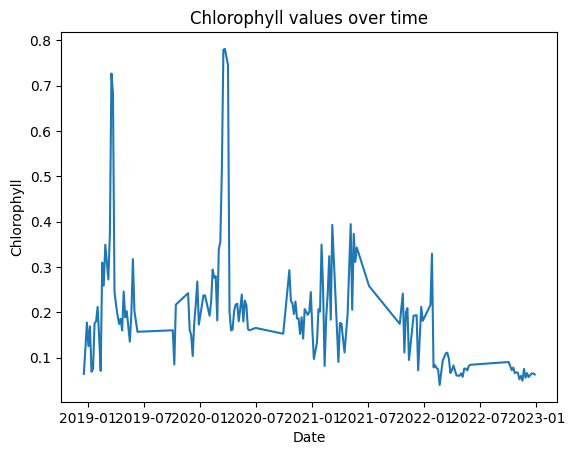

In [33]:
import matplotlib.pyplot as plt

# Plotting the Chlorophyll values over time
plt.plot(df.index, df['Chlorophyll'])

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Chlorophyll')
plt.title('Chlorophyll values over time')

# Show the plot
plt.show()

## Converting it to csv file format 

In [20]:
df.to_csv('Chlorophyll.csv')

In [21]:
from IPython.display import FileLink
FileLink('Chlorophyll.csv')


C:\Users\HP\Desktop\Omdena\Chlorophyll.csv

## NDTI Calculation 

In [22]:
def addNDTI(image):
  ndti = image.normalizedDifference(['B4', 'B3']).rename('NDTI')
  return image.addBands(ndti)
with_ndti = sentinel_AOI.map(addNDTI)

In [23]:
#Calculating the Average NDTI on every image in the image collection
def meanNDTI(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDTI']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('NDTI').getInfo()

In [24]:
Images_ndti = with_ndti.select('NDTI').toList(with_ndti.size())
ndti_coll = []
for i in range(Images_ndti.length().getInfo()):
  image = ee.Image(Images_ndti.get(i-1))
  temp_ndti = meanNDTI(image)
  ndti_coll.append(temp_ndti)

In [25]:
#Getting Dates from the Image Collection
dates = np.array(with_ndti.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [26]:
#Creating the Dataframe
df1 = pd.DataFrame(ndti_coll, index = day, columns = ['Turbidity'])
df1.index = pd.to_datetime(df1.index, format="%Y/%m/%d")
df1.sort_index(ascending = True, inplace = True)

In [34]:
df1

,Turbidity
2018-12-18,-0.012822
2018-12-23,-0.124983
2018-12-28,-0.132007
2019-01-02,-0.115318
2019-01-07,-0.135276
...,...
2022-12-02,-0.027292
2022-12-07,-0.030176
2022-12-17,-0.019145
2022-12-22,-0.022120


In [40]:
df1.to_csv('Turbidity.csv')

In [41]:
from IPython.display import FileLink
FileLink('Turbidity.csv')

C:\Users\HP\Desktop\Omdena\Turbidity.csv

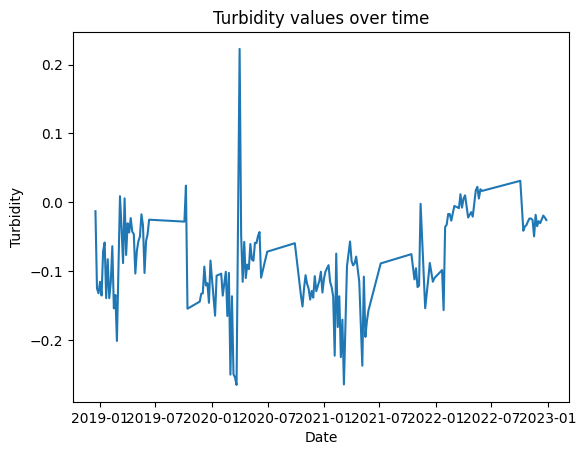

In [43]:
import matplotlib.pyplot as plt

# Plotting the Turbidity values over time
plt.plot(df1.index, df1['Turbidity'])

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Turbidity')
plt.title('Turbidity values over time')

# Show the plot
plt.show()

## NDSI Calculation------------Iterating over all the images

In [44]:
def addNDSI(image):
  ndsi = image.normalizedDifference(['B11', 'B12']).rename('NDSI')
  return image.addBands(ndsi)
with_ndsi = sentinel_AOI.map(addNDSI)

In [46]:
#Calculating the Average NDSI on every image in the image collection
def meanNDSI(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['NDSI']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('NDSI').getInfo()

In [47]:
Images_ndsi = with_ndsi.select('NDSI').toList(with_ndsi.size())
ndsi_coll = []
for i in range(Images_ndsi.length().getInfo()):
  image = ee.Image(Images_ndsi.get(i-1))
  temp_ndsi = meanNDSI(image)
  ndsi_coll.append(temp_ndsi)

In [48]:
#Getting Dates from the Image Collection
dates = np.array(with_ndsi.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [49]:
#Creating a Dataframe - For salinity
df2 = pd.DataFrame(ndsi_coll, index = day, columns = ['Salinty'])
df2.index = pd.to_datetime(df2.index, format="%Y/%m/%d")
df2.sort_index(ascending = True, inplace = True)

In [50]:
df2

,Salinty
2018-12-18,0.078672
2018-12-23,0.222540
2018-12-28,0.157764
2019-01-02,0.197524
2019-01-07,0.167815
...,...
2022-12-02,0.055130
2022-12-07,0.053584
2022-12-17,0.054299
2022-12-22,0.057018


In [53]:
df2.to_csv('Salinty.csv')
from IPython.display import FileLink
FileLink('Salinty.csv')

C:\Users\HP\Desktop\Omdena\Salinty.csv

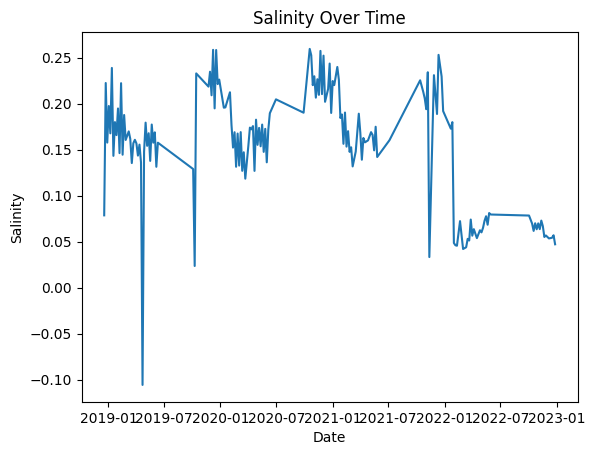

In [51]:
import matplotlib.pyplot as plt

# create line chart
plt.plot(df2.index, df2['Salinty'])

# set chart title and axis labels
plt.title('Salinity Over Time')
plt.xlabel('Date')
plt.ylabel('Salinity')

# display chart
plt.show()

## Dissloved Oxygen Calculation

In [54]:
# Iterating over all the images
def addDO(image):
  do = ee.Image(-0.0167).multiply(image.select('B8')).add(ee.Image(0.0067).multiply(image.select('B9'))).add(ee.Image(0.0083).multiply(image.select('B11'))).add(ee.Image(9.577)).rename('DO')
  return image.addBands(do)
with_do = sentinel_AOI.map(addDO)

### Calculating the Average Dissolved Oxygen Calculation on every image in the image collection

In [55]:
def meanDO(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['DO']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('DO').getInfo()

In [56]:
Images_do = with_do.select('DO').toList(with_do.size())
do_coll = []
for i in range(Images_do.length().getInfo()):
  image = ee.Image(Images_do.get(i-1))
  temp_do = meanDO(image)
  do_coll.append(temp_do)

### Getting Dates from the Image Collection

In [57]:
dates = np.array(with_do.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

### Creating a Dataframe

In [58]:
df4 = pd.DataFrame(do_coll, index = day, columns = ['Dissolved Oxygen'])
df4.index = pd.to_datetime(df4.index, format="%Y/%m/%d")
df4.sort_index(ascending = True, inplace = True)

In [59]:
df4

,Dissolved Oxygen
2018-12-18,7.252531
2018-12-23,11.367531
2018-12-28,11.038432
2019-01-02,11.474976
2019-01-07,11.321593
...,...
2022-12-02,11.077167
2022-12-07,9.678174
2022-12-17,9.980394
2022-12-22,12.020065


In [60]:
df4.to_csv('Dissolved Oxygen.csv')
from IPython.display import FileLink
FileLink('Dissolved Oxygen.csv')

C:\Users\HP\Desktop\Omdena\Dissolved Oxygen.csv

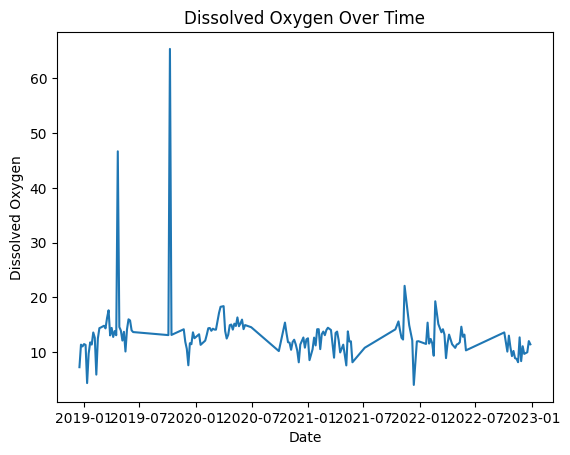

In [61]:
import matplotlib.pyplot as plt

# create line chart
plt.plot(df4.index, df4['Dissolved Oxygen'])

# set chart title and axis labels
plt.title('Dissolved Oxygen Over Time')
plt.xlabel('Date')
plt.ylabel('Dissolved Oxygen')

# display chart
plt.show()

# pH
### Iterating over all the images

In [62]:
def addpH(image):
  ph = ee.Image(8.339).subtract(ee.Image(0.827).multiply(image.select('B1').divide(image.select('B8')))).rename('PH')
  return image.addBands(ph)
with_pH = sentinel_AOI.map(addpH)

## Calculating the Average pH on every image in the image collection

In [63]:
def meanpH(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['PH']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('PH').getInfo()

In [64]:
Images_ph = with_pH.select('PH').toList(with_pH.size())
ph_coll= []
for i in range(Images_ph.length().getInfo()):
  image = ee.Image(Images_ph.get(i-1))
  temp_ph = meanpH(image)
  ph_coll.append(temp_ph)

## Getting Dates from the Image Collection

In [65]:
dates = np.array(with_pH.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

In [66]:
df6 = pd.DataFrame(ph_coll, index = day, columns = ['pH'])
df6.index = pd.to_datetime(df6.index, format="%Y/%m/%d")
df6.sort_index(ascending = True, inplace = True)

In [67]:
df6

,pH
2018-12-18,7.762265
2018-12-23,7.843140
2018-12-28,7.965211
2019-01-02,7.865017
2019-01-07,7.958572
...,...
2022-12-02,7.700644
2022-12-07,7.770612
2022-12-17,7.783132
2022-12-22,7.715950


In [68]:
df6.to_csv('pH.csv')
from IPython.display import FileLink
FileLink('pH.csv')

C:\Users\HP\Desktop\Omdena\pH.csv

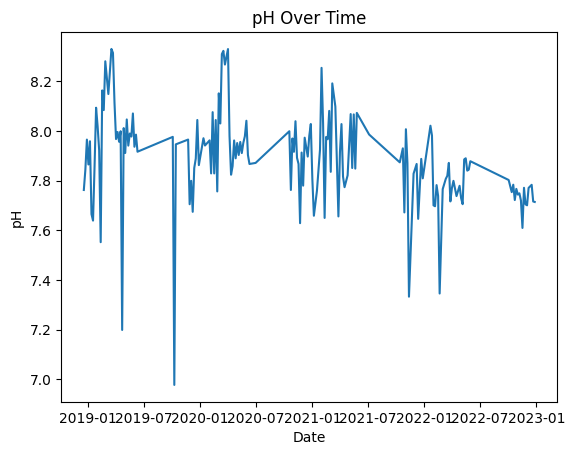

In [69]:
import matplotlib.pyplot as plt

# create line chart
plt.plot(df6.index, df6['pH'])

# set chart title and axis labels
plt.title('pH Over Time')
plt.xlabel('Date')
plt.ylabel('pH')

# display chart
plt.show()

# Temperature

In [70]:
# selecting the satellite 
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2").\
              filterDate("2016-01-01","2022-01-01")
BaalUdyan_AOI = ee.Geometry.Polygon([[77.42043846354407, 23.22515766027653],
          [77.42101245627326, 23.22513301178521],
          [77.4216132710926, 23.22511822268824],
          [77.42178493246955, 23.225063995985327],
          [77.42195122942847, 23.225197097853158],
          [77.4222087214939, 23.225571754250232],
          [77.42219799265784, 23.225847816185897],
          [77.4218493054859, 23.22590697224071],
          [77.42164009318275, 23.22578866010488],
          [77.42118948206824, 23.225857675530182],
          [77.42111974463386, 23.225660488506094],
          [77.42067449793738, 23.22557668393267],
          [77.42043309912604, 23.22563091042737],
          [77.42034190401954, 23.225768941405384],
          [77.42017560706061, 23.22578866010488],
          [77.42002540335578, 23.225625980746948],
          [77.41987519965095, 23.22542386369278],
          [77.41981619105262, 23.22522174633265]])

landsat_AOI = landsat.filterBounds(BaalUdyan_AOI)

### Printing the total number of images obtained from landsat

In [71]:
print('Total number of images :', landsat_AOI.size().getInfo())

Total number of images : 227


### Iterating all over the images

In [72]:
def addtemp(image):
  temp = image.select('ST_B.*').multiply(0.00341802).add(149.0).subtract(273.15).rename('temperature')
  return image.addBands(temp)
with_temp = landsat_AOI.map(addtemp)

### Calculating the Average Temperature on every image in the image collection

In [73]:
def meantemp(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['temperature']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('temperature').getInfo()

In [74]:
Images_temp = with_temp.select('temperature').toList(with_temp.size())
temp_coll = []
for i in range(Images_temp.length().getInfo()):
  image = ee.Image(Images_temp.get(i-1))
  tempe_temp = meantemp(image)
  temp_coll.append(tempe_temp)

### Getting Dates from the Image Collection

In [75]:
dates = np.array(with_temp.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

### Creating a Dataframe for temperature 

In [76]:
df5 = pd.DataFrame(temp_coll, index = day, columns = ['Temperature'])
df5.index = pd.to_datetime(df5.index, format="%Y/%m/%d")
df5.sort_index(ascending = True, inplace = True)

In [77]:
df5

,Temperature
2016-01-07,17.184291
2016-01-14,22.511921
2016-01-23,23.436686
2016-01-30,23.515442
2016-02-08,20.719778
...,...
2021-11-27,24.716207
2021-12-06,27.536062
2021-12-13,26.250454
2021-12-22,26.260312


In [78]:
df5.to_csv('Temperature.csv')
from IPython.display import FileLink
FileLink('Temperature.csv')

C:\Users\HP\Desktop\Omdena\Temperature.csv

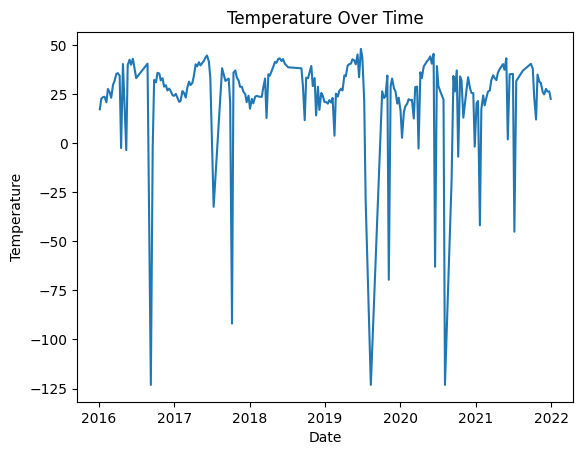

In [79]:
import matplotlib.pyplot as plt

# create line chart
plt.plot(df5.index, df5['Temperature'])

# set chart title and axis labels
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature')

# display chart
plt.show()

# Dissolved Oxygen Matter
#### Data collection through this satellite takes too long, try to give dates between short rangs as monthly or quartly

### Selecting the Satellite

In [92]:
sentinel3 = ee.ImageCollection("COPERNICUS/S3/OLCI").\
              filterDate("2018-01-01","2018-05-01")
BaalUdyan_AOI = ee.Geometry.Polygon([[77.42043846354407, 23.22515766027653],
          [77.42101245627326, 23.22513301178521],
          [77.4216132710926, 23.22511822268824],
          [77.42178493246955, 23.225063995985327],
          [77.42195122942847, 23.225197097853158],
          [77.4222087214939, 23.225571754250232],
          [77.42219799265784, 23.225847816185897],
          [77.4218493054859, 23.22590697224071],
          [77.42164009318275, 23.22578866010488],
          [77.42118948206824, 23.225857675530182],
          [77.42111974463386, 23.225660488506094],
          [77.42067449793738, 23.22557668393267],
          [77.42043309912604, 23.22563091042737],
          [77.42034190401954, 23.225768941405384],
          [77.42017560706061, 23.22578866010488],
          [77.42002540335578, 23.225625980746948],
          [77.41987519965095, 23.22542386369278],
          [77.41981619105262, 23.22522174633265]])
sentinel3_AOI = sentinel3.filterBounds(BaalUdyan_AOI)

In [93]:
print('Total number of images :', sentinel3_AOI.size().getInfo())

Total number of images : 458


In [94]:
#Iterating over all the images
def addDM(image):
  rgb = image.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'])\
              .multiply(ee.Image([0.00876539, 0.0123538, 0.0115198]))
  dm = rgb.select('Oa08_radiance').divide(rgb.select('Oa04_radiance')).rename('dom')
  return image.addBands(dm)
with_dm = sentinel3_AOI.map(addDM)

### Calculating the Average Dissolved Oxygen matter on every image in the image collection

In [99]:
def meanDM(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['dom']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('dom').getInfo()

In [ ]:
Images_dm = with_dm.select('dom').toList(with_dm.size())
dm_coll= []
for i in range(Images_dm.length().getInfo()):
  image = ee.Image(Images_dm.get(i-1))
  temp_dm = meanDM(image)
  dm_coll.append(temp_dm)

### Getting Dates from the Image Collection

In [ ]:
dates = np.array(with_dm.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

### Creating a Dataframe

In [ ]:
df3 = pd.DataFrame(dm_coll, index = day, columns = ['Dissolved Oxygen Matter'])
df3.index = pd.to_datetime(df3.index, format="%Y/%m/%d")
df3.sort_index(ascending = True, inplace = True)

In [ ]:
df3

# Suspended Matter
### Selecting the satellite 

In [5]:
sentinel3 = ee.ImageCollection("COPERNICUS/S3/OLCI").\
              filterDate("2018-01-01","2018-05-01")
BaalUdyan_AOI = ee.Geometry.Polygon([[77.42043846354407, 23.22515766027653],
          [77.42101245627326, 23.22513301178521],
          [77.4216132710926, 23.22511822268824],
          [77.42178493246955, 23.225063995985327],
          [77.42195122942847, 23.225197097853158],
          [77.4222087214939, 23.225571754250232],
          [77.42219799265784, 23.225847816185897],
          [77.4218493054859, 23.22590697224071],
          [77.42164009318275, 23.22578866010488],
          [77.42118948206824, 23.225857675530182],
          [77.42111974463386, 23.225660488506094],
          [77.42067449793738, 23.22557668393267],
          [77.42043309912604, 23.22563091042737],
          [77.42034190401954, 23.225768941405384],
          [77.42017560706061, 23.22578866010488],
          [77.42002540335578, 23.225625980746948],
          [77.41987519965095, 23.22542386369278],
          [77.41981619105262, 23.22522174633265]])
sentinel3_AOI = sentinel3.filterBounds(BaalUdyan_AOI)

In [6]:
#Printing the total number of images
print('Total number of images :', sentinel3_AOI.size().getInfo())

Total number of images : 458


In [7]:
# Iterating all over the images 
def addSM(image):
  rgb = image.select(['Oa08_radiance', 'Oa06_radiance', 'Oa04_radiance'])\
              .multiply(ee.Image([0.00876539, 0.0123538, 0.0115198]))
  suspended_matter = rgb.select('Oa08_radiance').divide(rgb.select('Oa06_radiance')).rename('suspended_matter')
  return image.addBands(suspended_matter)
with_sm = sentinel3_AOI.map(addSM)

## Calculating the Average Suspended Matter on every image in the image collection

In [10]:
def meanSM(image):
  image = ee.Image(image)
  mean = image.reduceRegion(reducer = ee.Reducer.mean().setOutputs(['suspended_matter']),
                           geometry = BaalUdyan_AOI,
                           scale = image.projection().nominalScale().getInfo(),
                           maxPixels = 100000,
                           bestEffort = True);
  return mean.get('suspended_matter').getInfo()

In [11]:
Images_sm = with_sm.select('suspended_matter').toList(with_sm.size())
sm_coll= []
for i in range(Images_sm.length().getInfo()):
  image = ee.Image(Images_sm.get(i-1))
  temp_sm = meanSM(image)
  sm_coll.append(temp_sm)

## Getting Dates from the Image Collection

In [12]:
dates = np.array(with_sm.aggregate_array("system:time_start").getInfo())
day = [datetime.datetime.fromtimestamp(i/1000).strftime('%Y-%m-%d') for i in (dates)]

## Creating a Dataframe

In [13]:
df7 = pd.DataFrame(sm_coll, index = day, columns = ['Suspended Matter'])
df7.index = pd.to_datetime(df7.index, format="%Y/%m/%d")
df7.sort_index(ascending = True, inplace = True)

In [14]:
df7

,Suspended Matter
2018-01-02,NaN
2018-01-03,0.543888
2018-01-06,0.532147
2018-01-07,0.541483
2018-01-10,0.513277
...,...
2018-04-30,NaN
2018-04-30,NaN
2018-05-01,NaN
2018-05-01,NaN


In [15]:
df7.to_csv('Suspended Matter.csv')
from IPython.display import FileLink
FileLink('Suspended Matter.csv')

C:\Users\HP\Desktop\Omdena\Suspended Matter.csv

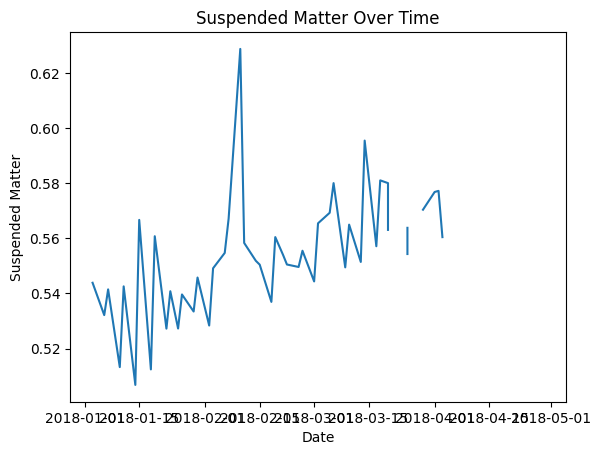

In [17]:
import matplotlib.pyplot as plt

# create line chart
plt.plot(df7.index, df7['Suspended Matter'])

# set chart title and axis labels
plt.title('Suspended Matter Over Time')
plt.xlabel('Date')
plt.ylabel('Suspended Matter')

# display chart
plt.show()